<center>
    <h1>Cloud Movement Diffusion</h1>
    <h2>Artificial Intelligence in Industry</h2>
    <h3>Facundo Nicolas Maidana, Farshid Mahmoudabadi, and Riccardo Spolaor</h3>
    <h4>riccardo.spolaor@studio.unibo.it</h4>
</center>

---

This project explores the use of diffusion models for short-term solar energy forecasting. Diffusion models are a type of generative model that can be used to predict the future state of a system by gradually "diffusing" from the current state. In this project, we train a diffusion model on a dataset of cloud images. We then use the model to predict the future state of the clouds, which can be used to forecast solar energy production.

Introduction:

Solar energy is a promising renewable energy source, but it is intermittent. This means that the amount of solar energy produced can vary significantly from day to day. Short-term solar energy forecasting can help to mitigate this variability by providing estimates of solar energy production in the near future.

Diffusion models:

Diffusion models are a type of generative model that can be used to predict the future state of a system by gradually "diffusing" from the current state. Diffusion models are trained on a dataset of images, and they can be used to generate new images that are similar to the images in the dataset.

Project goals:

The goals of this project are to:

Train a diffusion model on a dataset of cloud images.
Use the model to predict the future state of the clouds.
Use the predicted cloud state to forecast solar energy production.

Project results:

The results of this project show that diffusion models can be used to predict the future state of the clouds with some accuracy. The predicted cloud state can then be used to forecast solar energy production.

# Settings

In [1]:
# Settings for autoreloading.

%load_ext autoreload
%autoreload 2

In [2]:
!pip install -q wandb tqdm matplotlib diffusers fastcore fastprogress torchmetrics einops opencv-python


[notice] A new release of pip is available: 23.1.2 -> 23.3
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
from types import SimpleNamespace

# TODO: Some of these parameters are not used, remove them.
config = SimpleNamespace(
    epochs=101, # Number of epochs.
    model_name='unet_small', # Model name to save [unet_small, unet_big].
    strategy='ddpm', # Strategy to use ddpm.
    noise_steps=1_000, # Number of noise steps on the diffusion process.
    sampler_steps=333, # Number of sampler steps on the diffusion process.
    seed=42, # Random seed.
    batch_size=128, # Batch size.
    img_size=64, # Image size.
    device='cuda', # Device to use.
    num_workers=0, # Number of workers for dataloader.
    num_input_frames=3, # Number of frames to use as input for the training.
    lr=5e-4, # Learning rate.
    log_every_epoch=5, # Log every n epochs to wandb.
    num_prediction_frames=1, # Number of predictions to make.
    num_channels=1, # Number of channels.
    validate_epochs=False, # Whether to validate every epoch.
    )

# Dataset

In [4]:
import wandb
wandb.login()

wandb: Currently logged in as: maidacundo (arked). Use `wandb login --relogin` to force relogin


True

## Dataset class

## training

In [5]:
PROJECT_NAME = 'sevir'
DATASET_ARTIFACT = 'ai-industry/sevir/SEVIR:latest'
SCALERS_ARTIFACT = 'ai-industry/sevir/scalers:latest'

In [6]:
from src.scaler import Scaler

In [7]:
import torch

from src.seeder import set_seed
from src.model import get_unet_params
from src.dataset_builder import download_dataset, download_scalers

# Set the model parameters in the config file.
'''config.model_params = get_unet_params(
    model_name=config.model_name,
    num_frames=10)''';

# Set the model parameters in the config file.
# TODO: base num_frames on config
config.model_params = get_unet_params(
    model_name=config.model_name,
    num_input_frames=config.num_input_frames + config.num_prediction_frames,
    num_output_frames=config.num_prediction_frames,
    num_channels=config.num_channels
    )

# Set the seed and device.
set_seed(config.seed)
device = torch.device(config.device)

# Downlaod the dataset from the wandb Artifact.
files = download_dataset(DATASET_ARTIFACT, PROJECT_NAME)
scalers = download_scalers(SCALERS_ARTIFACT, PROJECT_NAME)

wandb: Downloading large artifact SEVIR:latest, 8544.38MB. 9 files... 
wandb:   9 of 9 files downloaded.  
Done. 0:0:3.2


wandb:   3 of 3 files downloaded.  


In [8]:
from src.dataset_builder import CloudDataset

# Build the train and validation datasets.
train_ds = CloudDataset(
    files=files[1:2], # Use just ir069 training images.
    num_frames=config.num_input_frames + config.num_prediction_frames, # Use 3 frames as input and 1 frame as prediction.
    img_size=config.img_size, # Image size.
    scalers=scalers[0:1] # Use just ir069 scaler.
    ).shuffle()
valid_ds = CloudDataset(
    files=files[2:3], # Use just ir069 validation images.
    num_frames=config.num_input_frames + config.num_prediction_frames, # Use 3 frames as input and 1 frame as target.
    img_size=config.img_size, # Image size.
    scalers=scalers[0:1]) # Use just ir069 scaler.

In [9]:
from src.dataloader import NoisifyDataloader, ValidationDataloader
from src.model import UNet2D
from src.sampler import ddim_sampler
from src.training import MiniTrainer


# Build the DDPM noise train and validation dataloaders.
train_dataloader = NoisifyDataloader(
    train_ds,
    config.batch_size,
    shuffle=True,
    n_frames_to_nosify=config.num_prediction_frames,
    num_workers=config.num_workers)

valid_dataloader = ValidationDataloader(
    valid_ds,
    config.batch_size,
    n_past_frames=config.num_input_frames,
    shuffle=False,
    num_workers=config.num_workers)

# Setup the model.
model = UNet2D(**config.model_params)

# Setup the sampler.
sampler = ddim_sampler(
    steps=config.sampler_steps,
    n_frames_to_predict=config.num_prediction_frames,
    n_channels=config.num_channels)

# Get the trainer.
trainer = MiniTrainer(
    train_dataloader,
    valid_dataloader,
    model,
    sampler,
    scalers[0],
    device,
    n_frames_to_predict=config.num_prediction_frames,
    n_auto_regression_steps=None)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


In [10]:
scaler = scalers[0]
import numpy as np
scaler.scale(np.array([-42.98]))

array([-0.38902073])

wandb: Currently logged in as: maidacundo (ai-industry). Use `wandb login --relogin` to force relogin


validation epoch=0, val PSNR=-3.738, val SSIM=-0.001, val MSE=0.540, val mCSI=0.742


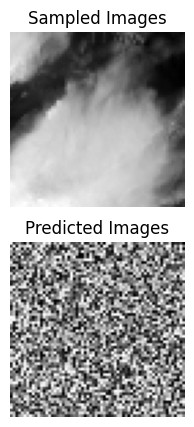

target_frames bounds:  -0.43845242 -0.31682485
predicted_frames bounds:  -1.0 1.0


validation epoch=5, val PSNR=-3.440, val SSIM=-0.000, val MSE=0.504, val mCSI=0.743


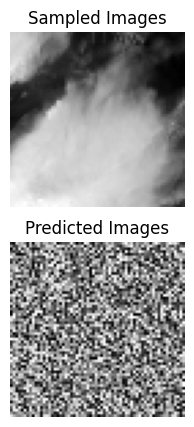

target_frames bounds:  -0.43845242 -0.31682485
predicted_frames bounds:  -1.0 1.0


validation epoch=10, val PSNR=-2.289, val SSIM=0.000, val MSE=0.387, val mCSI=0.747


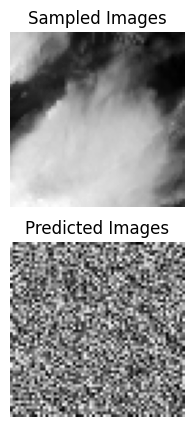

target_frames bounds:  -0.43845242 -0.31682485
predicted_frames bounds:  -1.0 1.0


validation epoch=15, val PSNR=0.776, val SSIM=0.014, val MSE=0.191, val mCSI=0.759


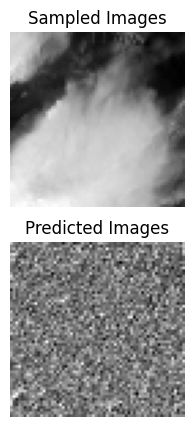

target_frames bounds:  -0.43845242 -0.31682485
predicted_frames bounds:  -0.8761703 0.84720397


validation epoch=20, val PSNR=7.127, val SSIM=0.441, val MSE=0.044, val mCSI=0.763


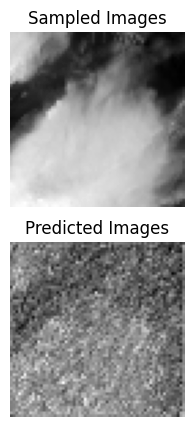

target_frames bounds:  -0.43845242 -0.31682485
predicted_frames bounds:  -0.37128937 -0.017958825


validation epoch=25, val PSNR=14.903, val SSIM=0.708, val MSE=0.007, val mCSI=0.774


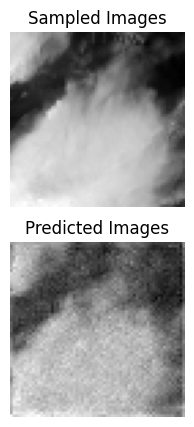

target_frames bounds:  -0.43845242 -0.31682485
predicted_frames bounds:  -0.41562128 -0.2533795


validation epoch=30, val PSNR=13.433, val SSIM=0.775, val MSE=0.010, val mCSI=0.778


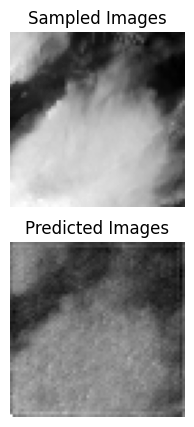

target_frames bounds:  -0.43845242 -0.31682485
predicted_frames bounds:  -0.39012775 -0.16636017


validation epoch=35, val PSNR=15.305, val SSIM=0.754, val MSE=0.007, val mCSI=0.773


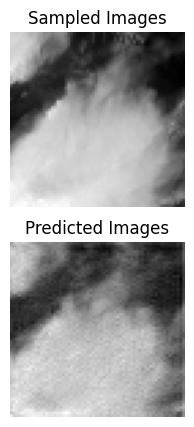

target_frames bounds:  -0.43845242 -0.31682485
predicted_frames bounds:  -0.40608 -0.25904527


validation epoch=40, val PSNR=18.544, val SSIM=0.818, val MSE=0.003, val mCSI=0.785


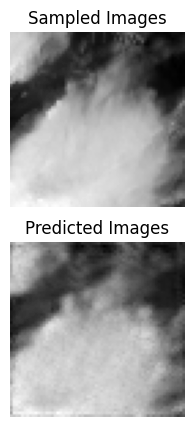

target_frames bounds:  -0.43845242 -0.31682485
predicted_frames bounds:  -0.4620186 -0.32227042


validation epoch=45, val PSNR=18.475, val SSIM=0.798, val MSE=0.003, val mCSI=0.786


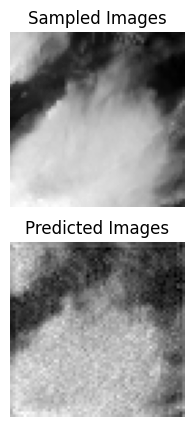

target_frames bounds:  -0.43845242 -0.31682485
predicted_frames bounds:  -0.39207178 -0.23763461


validation epoch=50, val PSNR=25.020, val SSIM=0.842, val MSE=0.001, val mCSI=0.804


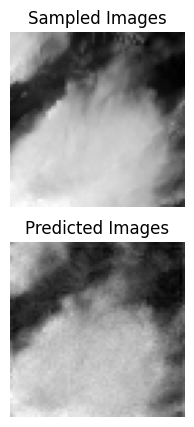

target_frames bounds:  -0.43845242 -0.31682485
predicted_frames bounds:  -0.42864063 -0.2908707


validation epoch=55, val PSNR=20.071, val SSIM=0.801, val MSE=0.002, val mCSI=0.791


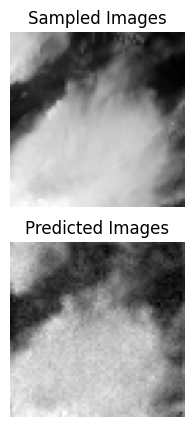

target_frames bounds:  -0.43845242 -0.31682485
predicted_frames bounds:  -0.42297888 -0.28971767


validation epoch=60, val PSNR=24.664, val SSIM=0.767, val MSE=0.001, val mCSI=0.817


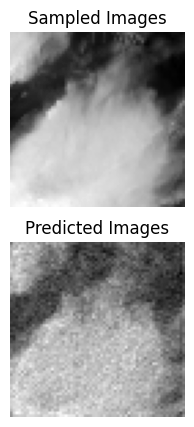

target_frames bounds:  -0.43845242 -0.31682485
predicted_frames bounds:  -0.42677954 -0.25951558


validation epoch=65, val PSNR=23.903, val SSIM=0.793, val MSE=0.001, val mCSI=0.812


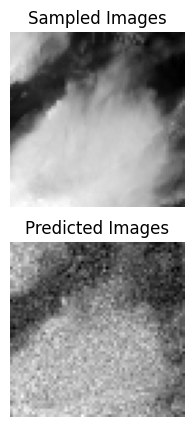

target_frames bounds:  -0.43845242 -0.31682485
predicted_frames bounds:  -0.44747585 -0.26263574


validation epoch=70, val PSNR=27.138, val SSIM=0.793, val MSE=0.000, val mCSI=0.830


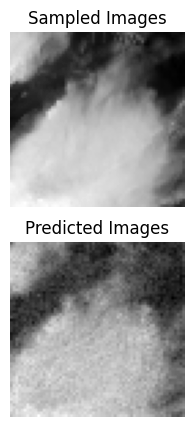

target_frames bounds:  -0.43845242 -0.31682485
predicted_frames bounds:  -0.4334213 -0.2792618


validation epoch=75, val PSNR=29.386, val SSIM=0.807, val MSE=0.000, val mCSI=0.844


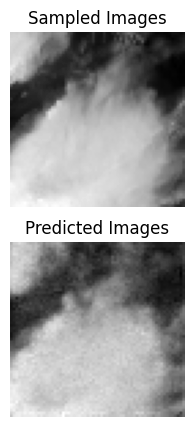

target_frames bounds:  -0.43845242 -0.31682485
predicted_frames bounds:  -0.43780202 -0.2995164


validation epoch=80, val PSNR=31.243, val SSIM=0.804, val MSE=0.000, val mCSI=0.857


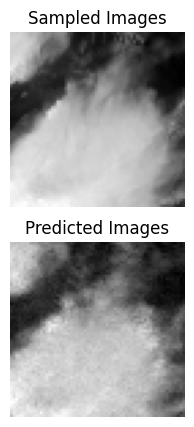

target_frames bounds:  -0.43845242 -0.31682485
predicted_frames bounds:  -0.44514838 -0.31376734


validation epoch=85, val PSNR=28.947, val SSIM=0.796, val MSE=0.000, val mCSI=0.845


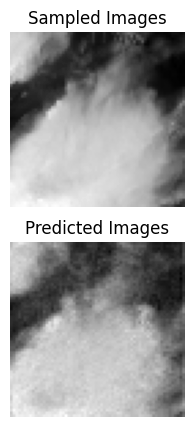

target_frames bounds:  -0.43845242 -0.31682485
predicted_frames bounds:  -0.42770973 -0.28923094


validation epoch=90, val PSNR=30.679, val SSIM=0.780, val MSE=0.000, val mCSI=0.850


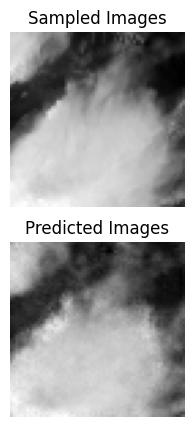

target_frames bounds:  -0.43845242 -0.31682485
predicted_frames bounds:  -0.43933696 -0.30905396


validation epoch=95, val PSNR=30.265, val SSIM=0.784, val MSE=0.000, val mCSI=0.844


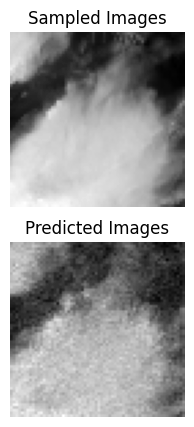

target_frames bounds:  -0.43845242 -0.31682485
predicted_frames bounds:  -0.42858338 -0.28040338


validation epoch=100, val PSNR=30.515, val SSIM=0.782, val MSE=0.000, val mCSI=0.848


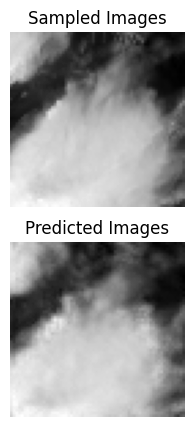

target_frames bounds:  -0.43845242 -0.31682485
predicted_frames bounds:  -0.4468956 -0.32247892


learning_rate,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁
train_mse,██▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_m_csi,▁▁▁▂▂▃▃▃▄▄▅▄▆▅▆▇█▇█▇▇
val_mse,██▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_psnr,▁▁▁▂▃▅▄▅▅▅▇▆▇▇▇██████
val_ssim,▁▁▁▁▅▇▇▇████▇█████▇██
learning_rate,0.0
train_mse,0.00071
val_m_csi,0.84771
val_mse,0.0002
val_psnr,30.5146


In [11]:
# trainer = MiniTrainer(train_dataloader, valid_dataloader, model, sampler, device)

# Train the model.
with wandb.init(
    project='cloud-diffuser-baseline',
    entity='ai-industry',
    config=config,
    tags=['ddpm', config.model_name]
    ):
    histories = trainer.fit(config)

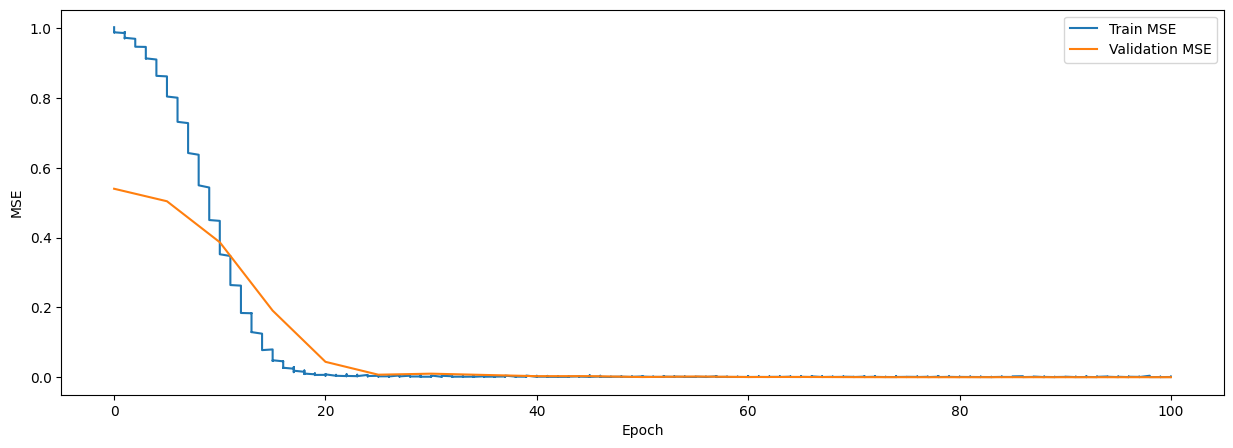

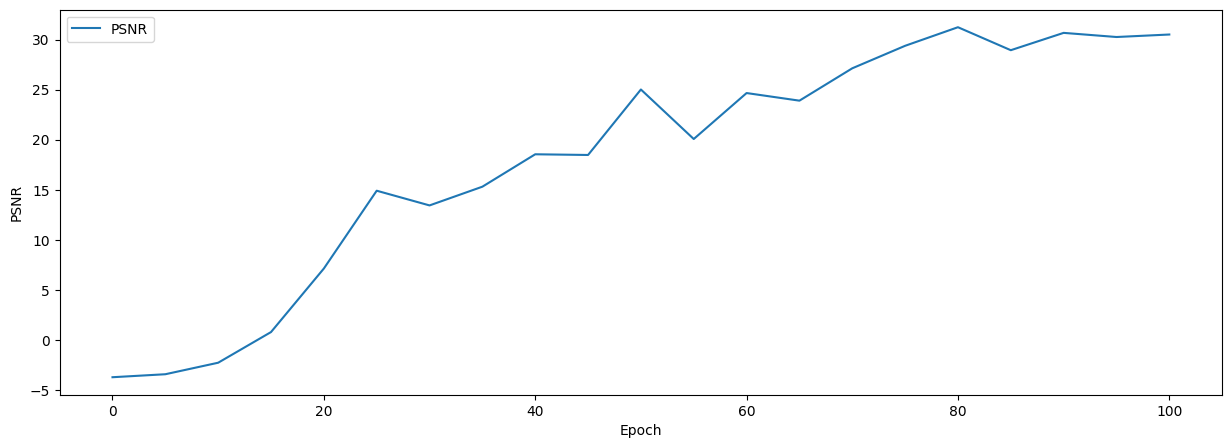

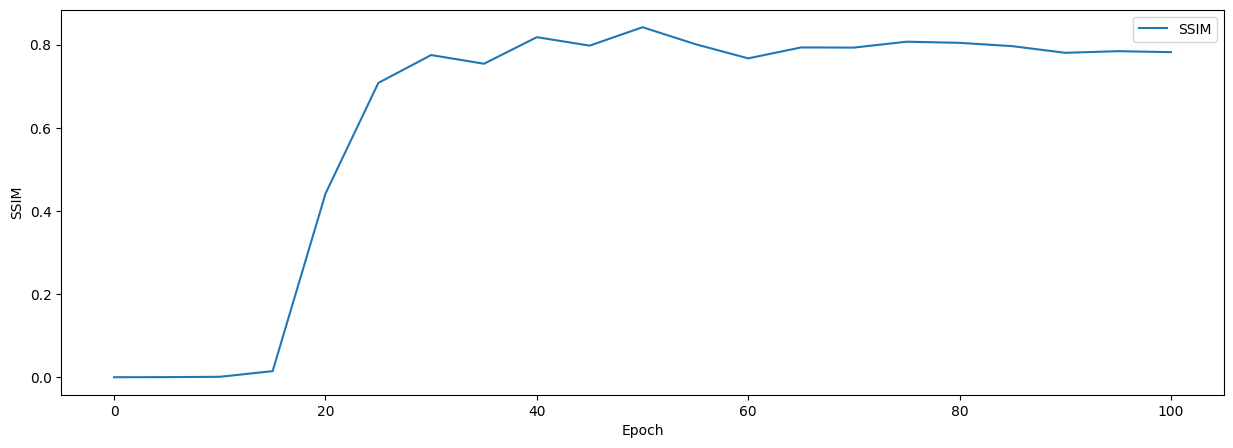

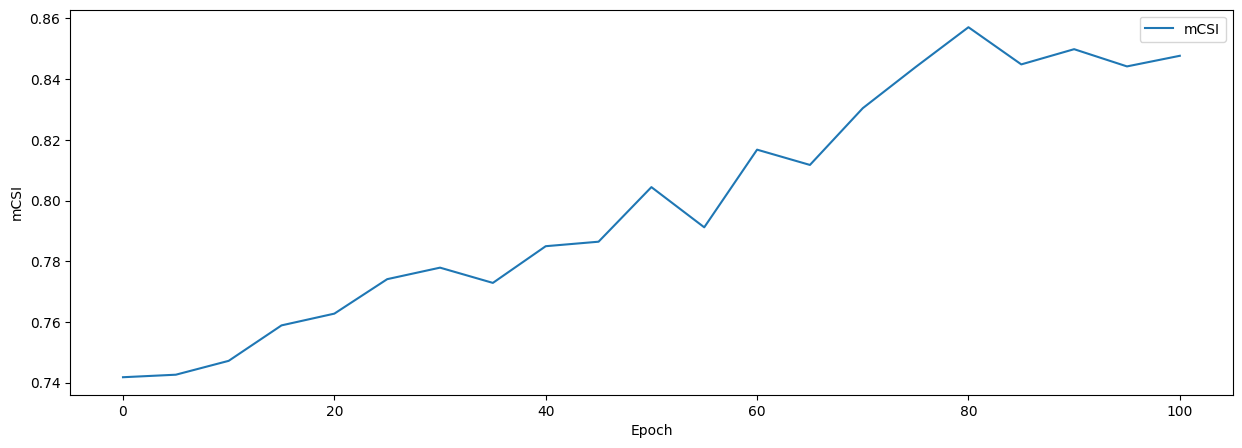

In [13]:
from src.visualization import plot_metrics

plot_metrics(
    *histories[:2],
    PSNR=histories[2],
    SSIM=histories[3],
    mCSI=histories[4])